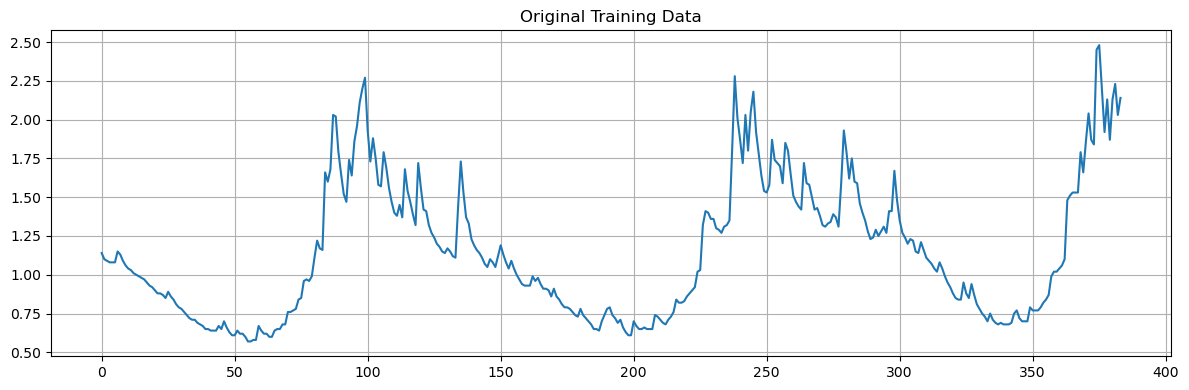

ADF Statistic (d=0): -1.5890886911590594
p-value: 0.48907228946950876
=> Not stationary. Try differencing (d=1).


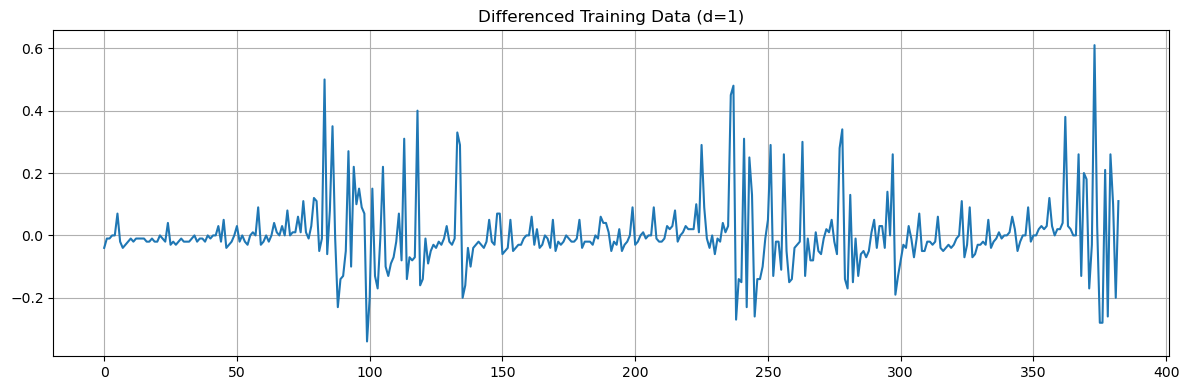

ADF Statistic (d=1): -16.027116714850337
p-value: 6.114120445783985e-29
=> Now stationary. Use d=1.


In [ ]:
#finne D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import os

# Save path
save_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/ARIMAMODELLER/Datset_1/Dataset1grafer"
os.makedirs(save_path, exist_ok=True)

# Load data and split 80/20
file_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/CPU_DATA FRA KAGGLE/Test/ww/datasets/gauravduttakiit/cpu-utilization/cpu-full-a.csv"
df = pd.read_csv(file_path)
data = df['cpu'].values

split_index = int(len(data) * 0.8)
train = data[:split_index]
test = data[split_index:]

# Plot original training data
plt.figure(figsize=(12, 4))
plt.plot(train)
plt.title("Original Training Data")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "Original_Training_Data.png"), bbox_inches='tight')
plt.show()

# ADF test for d = 0
adf_result = adfuller(train)
print("ADF Statistic (d=0):", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] > 0.05:
    print("=> Not stationary. Try differencing (d=1).")
else:
    print("=> Series is stationary. d=0 is likely good.")

# Try differencing
diff_train = np.diff(train, n=1)

# Plot differenced data
plt.figure(figsize=(12, 4))
plt.plot(diff_train)
plt.title("Differenced Training Data (d=1)")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "Differenced_Training_Data_d1.png"), bbox_inches='tight')
plt.show()

# ADF test on differenced data
adf_result_diff = adfuller(diff_train)
print("ADF Statistic (d=1):", adf_result_diff[0])
print("p-value:", adf_result_diff[1])
if adf_result_diff[1] > 0.05:
    print("=> Still not stationary. Try d=2.")
else:
    print("=> Now stationary. Use d=1.")


<Figure size 1200x400 with 0 Axes>

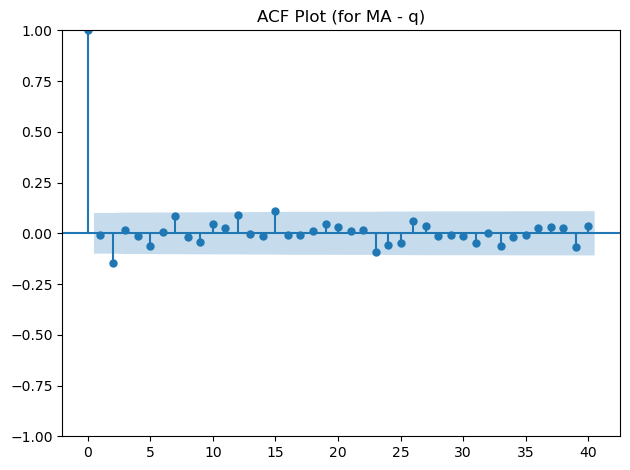

<Figure size 1200x400 with 0 Axes>

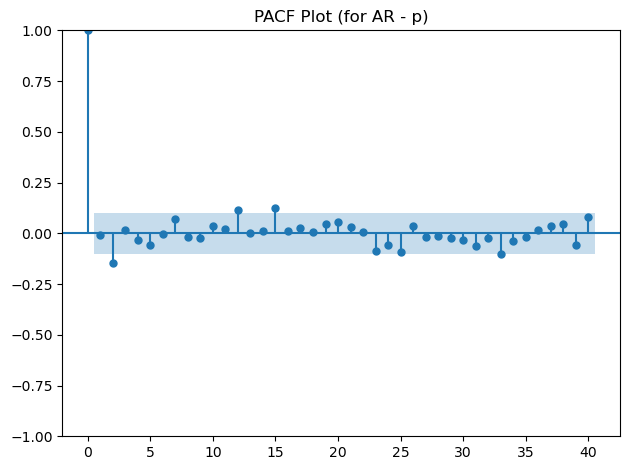


Suggested q (from ACF): 2
Suggested p (from PACF): 2


In [ ]:
#finne p og q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
import numpy as np
import os

# Save path
save_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/ARIMAMODELLER/Datset_1/Dataset1grafer"
os.makedirs(save_path, exist_ok=True)

# Use the differenced series
d = 1  # Adjust if you've determined a different value
series_for_acf_pacf = np.diff(train, n=d) if d > 0 else train

# Plot and save ACF
plt.figure(figsize=(12, 4))
plot_acf(series_for_acf_pacf, lags=40)
plt.title("ACF Plot (for MA - q)")
plt.tight_layout()
plt.savefig(os.path.join(save_path, "ACF_Plot_for_MA_q.png"), bbox_inches='tight')
plt.show()

# Plot and save PACF
plt.figure(figsize=(12, 4))
plot_pacf(series_for_acf_pacf, lags=40)
plt.title("PACF Plot (for AR - p)")
plt.tight_layout()
plt.savefig(os.path.join(save_path, "PACF_Plot_for_AR_p.png"), bbox_inches='tight')
plt.show()

# Auto-suggest p and q
threshold = 1.96 / np.sqrt(len(series_for_acf_pacf))

acf_vals = acf(series_for_acf_pacf, nlags=40)
pacf_vals = pacf(series_for_acf_pacf, nlags=40)

suggested_q = next((i for i, val in enumerate(acf_vals[1:], start=1) if abs(val) > threshold), 0)
suggested_p = next((i for i, val in enumerate(pacf_vals[1:], start=1) if abs(val) > threshold), 0)

print(f"\nSuggested q (from ACF): {suggested_q}")
print(f"Suggested p (from PACF): {suggested_p}")



=== Forecast from 80% training ===


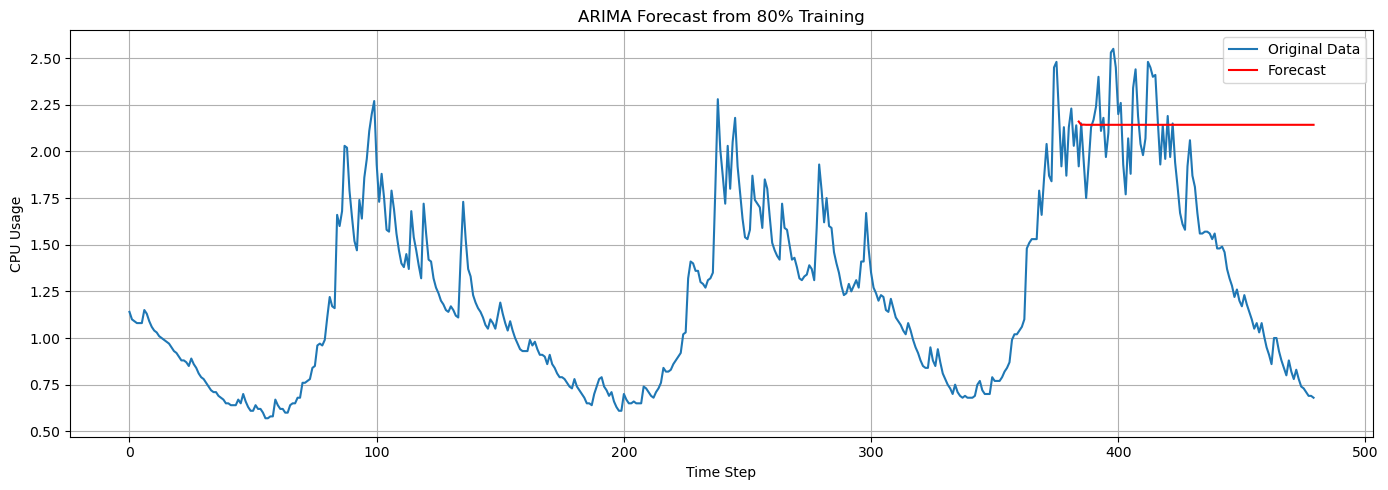

MAE:   0.6122
MSE:   0.5995
MAPE:  58.08%
PMAPE: 59.58%

=== Forecast from 75% training ===


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


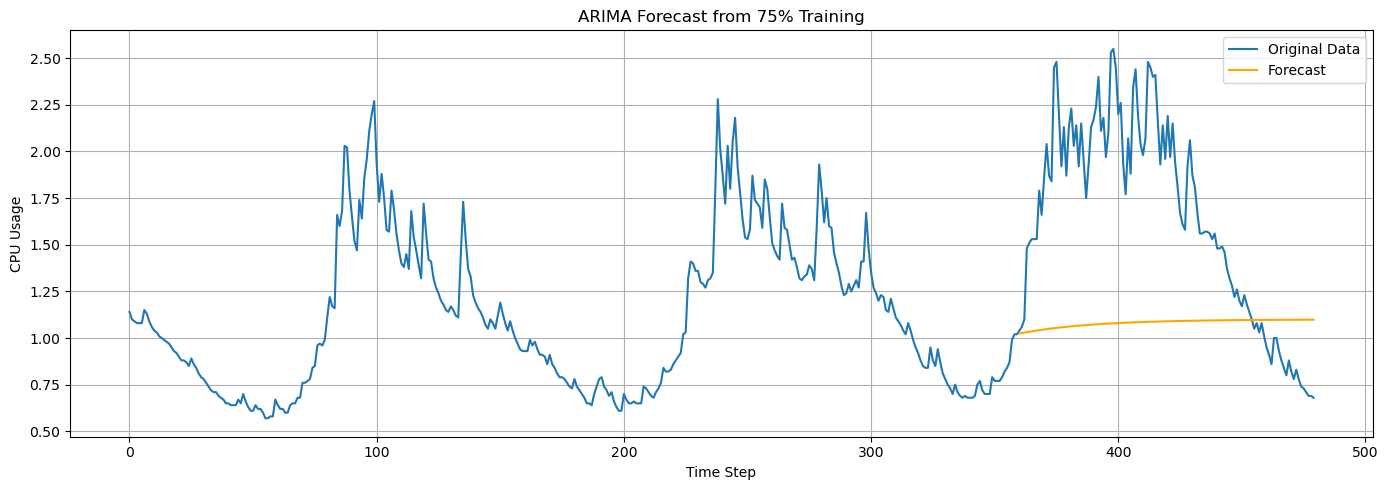

MAE:   0.6583
MSE:   0.6097
MAPE:  36.58%
PMAPE: 67.15%

=== Forecast from 60% training ===


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


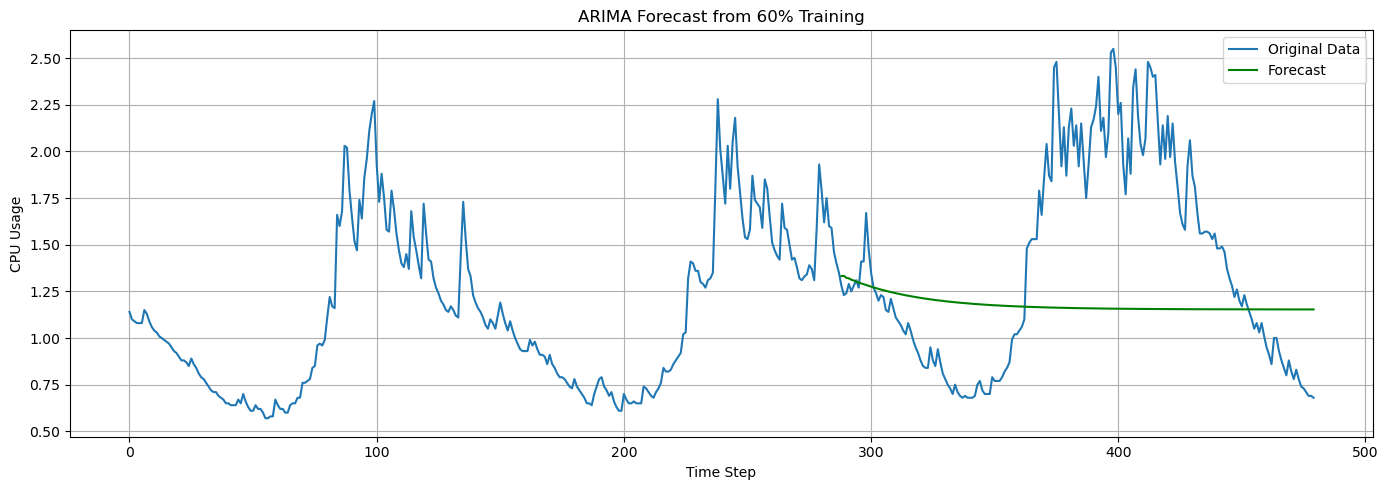

MAE:   0.4843
MSE:   0.3637
MAPE:  34.30%
PMAPE: 51.60%


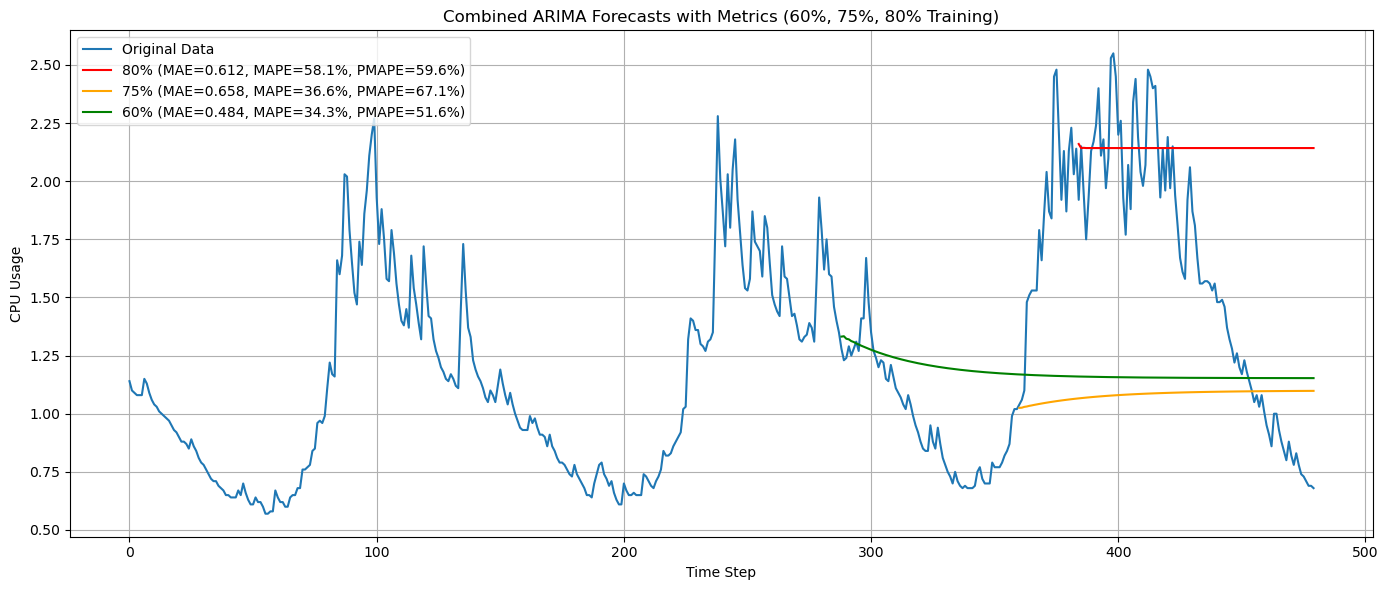

In [ ]:
# for plots med 60%, 70% og 80% training data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# Save path
save_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/ARIMAMODELLER/Datset_1/Dataset1grafer"
os.makedirs(save_path, exist_ok=True)

# load data
file_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/CPU_DATA FRA KAGGLE/Test/ww/datasets/gauravduttakiit/cpu-utilization/cpu-full-a.csv"
df = pd.read_csv(file_path)
data = df['cpu'].values

# ARIMA config
p, d, q = 2, 1, 2

# Custom Penalized MAPE function
def penalized_mape(y_true, y_pred, penalty=2.0):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    error = np.abs(y_true - y_pred)
    penalized_error = np.where(y_pred < y_true, error * penalty, error)
    percentage_error = penalized_error / np.maximum(np.abs(y_true), 1e-8)
    return np.mean(percentage_error) * 100

# Define splits and
splits = {
    0.8: 'red',
    0.75: 'orange',
    0.6: 'green'
}

# Save forecasts and metrics for combined plot
forecasts_dict = {}

# Plot individually with metrics
for split, color in splits.items():
    print(f"\n=== Forecast from {int(split*100)}% training ===")
    split_index = int(len(data) * split)
    train = data[:split_index]
    test = data[split_index:]

    try:
        model = ARIMA(train, order=(p, d, q))
        fitted_model = model.fit()
        forecast = fitted_model.forecast(steps=len(test))

        # Calculate metrics
        mae = mean_absolute_error(test, forecast)
        mse = mean_squared_error(test, forecast)
        mape = np.mean(np.abs((test - forecast) / test)) * 100
        pmape = penalized_mape(test, forecast, penalty=2.0)

        # Save for combined plot
        forecasts_dict[split_index] = {
            'forecast': forecast,
            'color': color,
            'label': f"{int(split*100)}% (MAE={mae:.3f}, MAPE={mape:.1f}%, PMAPE={pmape:.1f}%)"
        }

        # Plot and save individual
        plt.figure(figsize=(14, 5))
        plt.plot(data, label="Original Data", color='tab:blue')
        plt.plot(range(split_index, len(data)), forecast, label="Forecast", color=color)
        plt.title(f"ARIMA Forecast from {int(split*100)}% Training")
        plt.xlabel("Time Step")
        plt.ylabel("CPU Usage")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        filename = f"ARIMA_Forecast_{int(split*100)}_Training.png"
        plt.savefig(os.path.join(save_path, filename), bbox_inches='tight')
        plt.show()

        # Print metrics
        print(f"MAE:   {mae:.4f}")
        print(f"MSE:   {mse:.4f}")
        print(f"MAPE:  {mape:.2f}%")
        print(f"PMAPE: {pmape:.2f}%")

    except Exception as e:
        print(f"❌ Forecast failed for split {int(split*100)}%: {e}")

# Combined plot
plt.figure(figsize=(14, 6))
plt.plot(data, label="Original Data", color='tab:blue')

for split_index, details in forecasts_dict.items():
    forecast = details['forecast']
    color = details['color']
    label = details['label']
    x_range = range(split_index, split_index + len(forecast))
    plt.plot(x_range, forecast, label=label, color=color)

plt.title("Combined ARIMA Forecasts with Metrics (60%, 75%, 80% Training)")
plt.xlabel("Time Step")
plt.ylabel("CPU Usage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "ARIMA_Combined_Forecasts.png"), bbox_inches='tight')
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-446.775, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-448.683, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-446.992, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-447.102, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-450.670, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-447.936, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.061 seconds

=== Forecast from 60% training ===
Best ARIMA order: (0, 1, 0)
MAE:   0.4785
RMSE:  0.5535
MAPE:  38.89%
PMAPE: 51.51%
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-613.320, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1137.961, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=684.380, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-615.012, Time=0.13 s

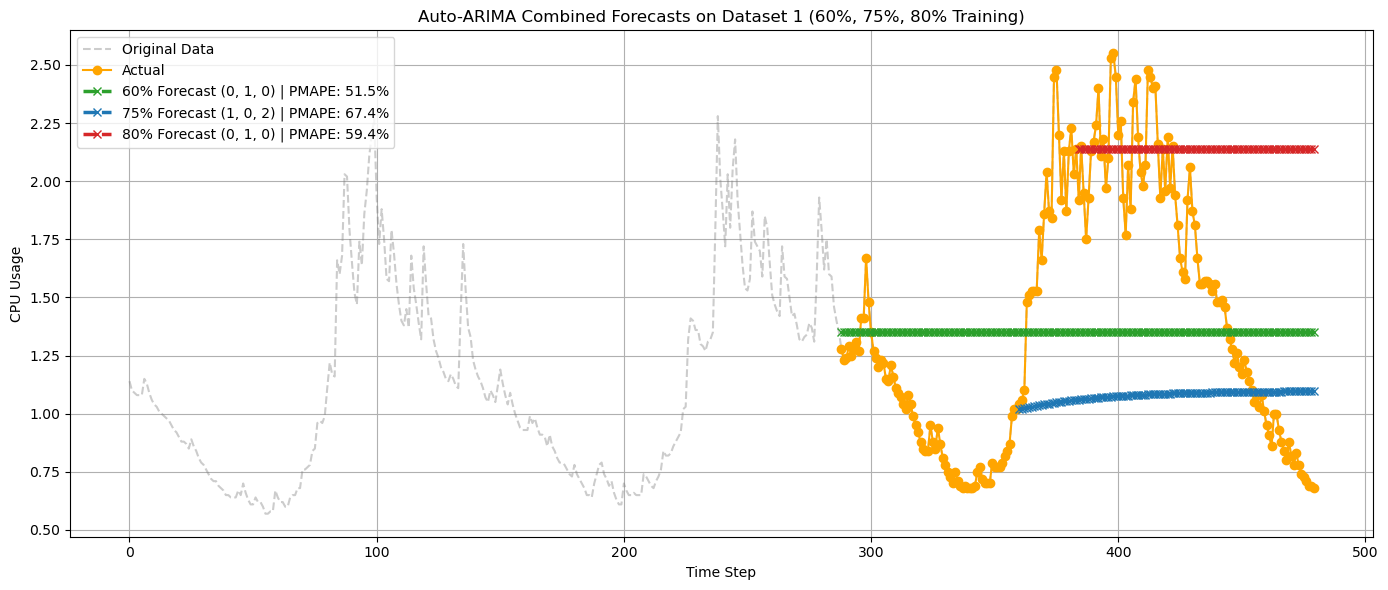

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# Set save path 
save_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/ARIMAMODELLER/Datset_1/Dataset1grafer"
os.makedirs(save_path, exist_ok=True)

# Load Dataset 1
file_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/CPU_DATA FRA KAGGLE/Test/ww/datasets/gauravduttakiit/cpu-utilization/cpu-full-a.csv"
df = pd.read_csv(file_path)
cpu_series = df['cpu'].values

#Penalized MAPE function 
def penalized_mape(y_true, y_pred, penalty=2.0):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    error = np.abs(y_true - y_pred)
    penalized_error = np.where(y_pred < y_true, error * penalty, error)
    percentage_error = penalized_error / np.maximum(np.abs(y_true), 1e-8)
    return np.mean(percentage_error) * 100

# Define training splits 
splits = {
    0.6: 'tab:green',
    0.75: 'tab:blue',
    0.8: 'tab:red'
}

# Store forecasts and metrics
combined_forecasts = {}

# Loop through each split and run Auto-ARIMA
for split, color in splits.items():
    split_index = int(len(cpu_series) * split)
    train = cpu_series[:split_index]
    test = cpu_series[split_index:]

    try:
        model = auto_arima(train,
                           seasonal=False,
                           stepwise=True,
                           suppress_warnings=True,
                           error_action='ignore',
                           trace=True)  # Shows the training process

        fitted_model = model.fit(train)
        forecast = fitted_model.predict(n_periods=len(test))

        # Evaluation metrics
        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mape = np.mean(np.abs((test - forecast) / test)) * 100
        pmape = penalized_mape(test, forecast, penalty=2.0)

        print(f"\n=== Forecast from {int(split*100)}% training ===")
        print(f"Best ARIMA order: {model.order}")
        print(f"MAE:   {mae:.4f}")
        print(f"RMSE:  {rmse:.4f}")
        print(f"MAPE:  {mape:.2f}%")
        print(f"PMAPE: {pmape:.2f}%")

        # Store for combined plot
        combined_forecasts[split] = {
            'forecast': forecast,
            'split_index': split_index,
            'color': color,
            'pmape': pmape,
            'order': model.order
        }

    except Exception as e:
        print(f"❌ Forecast failed for {int(split*100)}% split: {e}")

# Create combined plot
plt.figure(figsize=(14, 6))
plt.plot(cpu_series, label="Original Data", color='gray', linestyle='--', alpha=0.4)

# Plot actual segment
min_split = min([v['split_index'] for v in combined_forecasts.values()])
plt.plot(range(min_split, len(cpu_series)), cpu_series[min_split:], 
         label="Actual", color='orange', marker='o', linewidth=1.5)

# Plot each forecast
for split, result in combined_forecasts.items():
    start = result['split_index']
    forecast = result['forecast']
    color = result['color']
    pmape = result['pmape']
    order = result['order']
    x_range = range(start, start + len(forecast))
    plt.plot(x_range, forecast,
             label=f"{int(split*100)}% Forecast {order} | PMAPE: {pmape:.1f}%",
             color=color, linestyle='--', linewidth=2.5, marker='x')

plt.title("Auto-ARIMA Combined Forecasts on Dataset 1 (60%, 75%, 80% Training)")
plt.xlabel("Time Step")
plt.ylabel("CPU Usage")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Saves the plot
combined_path = os.path.join(save_path, "AutoARIMA_Dataset1_Combined.png")
plt.savefig(combined_path, dpi=300)
plt.show()
